In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

Data Handling

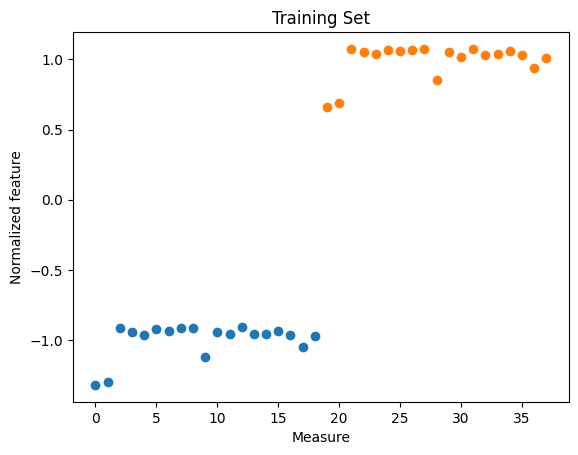

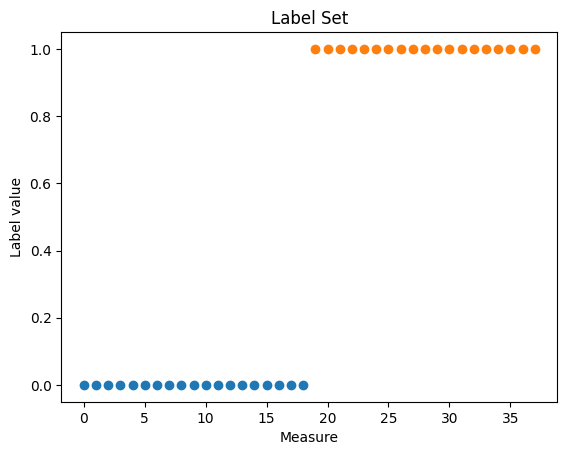

In [61]:
#Load and rehape the training and labels
X = np.load('./3_Extra/training_data/Classification_for_fibers.npy').reshape(-1, 1)
y = np.load('./3_Extra/training_data/fibers_labels.npy').reshape(-1, 1)
y = y.ravel()
#Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)
#Plot the data
plt.scatter(list(range(0, 19)), X[list(range(0, 19))])
plt.scatter(list(range(19, 38)), X[list(range(19, 38))])
plt.ylabel("Normalized feature")
plt.xlabel("Measure")
plt.title("Training Set")
plt.show()
plt.scatter(list(range(0, 19)), y[list(range(0, 19))])
plt.scatter(list(range(19, 38)), y[list(range(19, 38))])
plt.title("Label Set")
plt.ylabel("Label value")
plt.xlabel("Measure")
plt.show()

Training

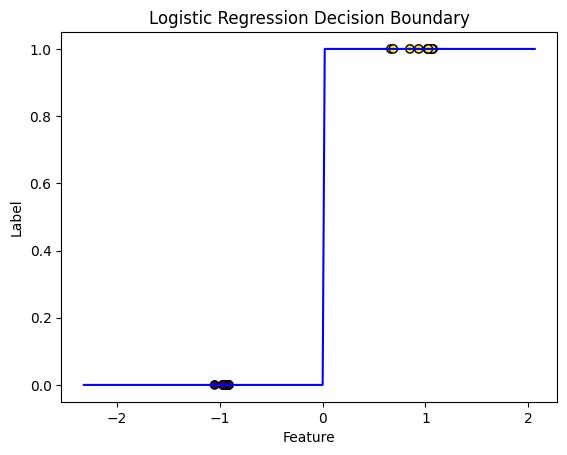

In [90]:
#Create and train the model
classifier = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
classifier.fit(X_train, y_train)
x_min, x_max = X.min() - 1, X.max() + 1
xx = np.arange(x_min, x_max, 0.02).reshape(-1, 1) #Independent array that covers all values to be predicted 
Z = classifier.predict(xx)
plt.plot(xx, Z, color='blue')
plt.scatter(X_train, y_train, c=y_train, edgecolors='k')
plt.xlabel('Feature')
plt.ylabel('Label')
plt.title('Logistic Regression Decision Boundary')
plt.show()

Testing

In [63]:
#PRedict and compare values of the test set
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 1.0


In [64]:
#Get the parameters of the model
weights = classifier.coef_
bias = classifier.intercept_
print("Weights:", weights[0][0])
print("Bias:", bias[0])

Weights: 2.4293425578612124
Bias: 0.009285330280983614


Crossvalidation method

In [65]:
classifier2 = LogisticRegression()
cv_scores = cross_val_score(classifier2, X, y, cv=5)  # 5-fold cross-validation
classifier2.fit(X, y)
print("Accuracy scores for each fold:", cv_scores)
print("Mean accuracy:", np.mean(cv_scores))
print("Standard deviation:", np.std(cv_scores))
classifier_score = classifier2.score(X, y)

Accuracy scores for each fold: [1. 1. 1. 1. 1.]
Mean accuracy: 1.0
Standard deviation: 0.0
